In [1]:
%pylab inline
import requests, zipfile
import StringIO
import datetime
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# find csv file for 2016-12
basepath = 'tripdata/'

year = 2017
month = 3
csvPath = '{}{:02}-citibike-tripdata.csv'.format(year, month)
df = pd.read_csv(basepath + csvPath, parse_dates = ['Start Time', 'Stop Time'])

In [3]:
#rename columns
new_cols = {'Trip Duration':'duration',
            'Start Time': 'start_time',
            'Stop Time':'stop_time', 
            'Start Station ID':'start_id',
            'Start Station Name':'start_name',
            'Start Station Latitude':'start_lat',
            'Start Station Longitude':'start_long', 
            'End Station ID':'stop_id', 
            'End Station Name':'stop_name',
            'End Station Latitude':'stop_lat', 
            'End Station Longitude':'stop_long',
            'Bike ID':'bike_id',
            'User Type':'user_type', 
            'Birth Year':'birth_year', 
            'Gender':'gender'}

df = df.rename(columns = new_cols)

In [4]:
# add a column called trip_id within
df['trip_id'] = df.index.values

# remove outlier (lat 0, long 0)
df = df[~(df.stop_lat == 0.)]

In [44]:
#load stations.csv or create a stations df from tripdata
import os
if os.path.exists('stations.csv'):
    stations = pd.read_csv('stations.csv', index_col='id')
else:    
    stations = df.groupby('start_id')['start_name', 'start_lat',
           'start_long'].aggregate(lambda x: x.value_counts().index[0])
    stations.columns = ['name','lat','long']
    stations.index.name = 'id'
    stations.sort_index(inplace = True)
    stations.to_csv('stations.csv')
    
stations.head()

,name,lat,long
id,,,
72,W 52 St & 11 Ave,40.767272,-73.993929
79,Franklin St & W Broadway,40.719116,-74.006667
82,St James Pl & Pearl St,40.711174,-74.000165
83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
116,W 17 St & 8 Ave,40.741776,-74.001497


In [45]:
station_count = -1*df.groupby(['start_id'])['duration'].count().to_frame()
station_count.rename(columns = {'duration' : 'out'}, inplace = True)
station_count.index.rename('station_id', inplace = True)
station_count['in'] = df.groupby(['stop_id'])['duration'].count()
station_count['total'] = station_count['in'] - station_count['out']
station_count['diff'] = station_count['in'] + station_count['out']
station_count.sort_values(by = 'total', ascending = False, inplace = True)
station_count['name'] = [stations.loc[x, 'name'] for x in station_count.index]
station_count.rename(index = str, inplace = True)

## Interesting stats

In [6]:
print "Total trips for {}-{:02}: {}".format(year, month, df.shape[0])

Total trips for 2017-03: 727664


In [7]:
sub_trips = df[df.user_type == 'Subscriber'].shape[0] / float(df.shape[0])
print "% subscribers: {:.3f}".format(100*sub_trips)

% subscribers: 95.614


In [8]:
male_trips = df[df.gender == 1].shape[0] / float(df.shape[0])
female_trips = df[df.gender == 2].shape[0] / float(df.shape[0])# add a column called trip_id within
print "% Male trips: {:.3f}".format(100*male_trips)
print "% Female trips: {:.3f}".format(100*female_trips)
print "% other trips: {:.3f}".format(100*(1 - male_trips - female_trips))

% Male trips: 74.038
% Female trips: 21.091
% other trips: 4.870


In [9]:
# top 10 starting locations
top_starts = df.groupby(['start_name', 'start_lat', 'start_long']).count().duration.sort_values(ascending = False)
top_starts = top_starts.reset_index()
top_starts.head()

,start_name,start_lat,start_long,duration
0,Pershing Square North,40.751873,-73.977706,9076
1,E 17 St & Broadway,40.737050,-73.990093,5443
2,W 21 St & 6 Ave,40.741740,-73.994156,5305
3,W 33 St & 7 Ave,40.750200,-73.990931,5293
4,Broadway & E 22 St,40.740343,-73.989551,5173


In [10]:
# top 10 stopping locations
top_stops = df.groupby(['stop_name', 'stop_lat', 'stop_long']).count().duration.sort_values(ascending = False)
top_stops = top_stops.reset_index()
top_stops.head()

,stop_name,stop_lat,stop_long,duration
0,Pershing Square North,40.751873,-73.977706,9014
1,W 33 St & 7 Ave,40.750200,-73.990931,6312
2,E 17 St & Broadway,40.737050,-73.990093,5894
3,Broadway & E 22 St,40.740343,-73.989551,5608
4,W 21 St & 6 Ave,40.741740,-73.994156,5375


In [11]:
top_stops[top_stops.stop_long == 0]

,stop_name,stop_lat,stop_long,duration


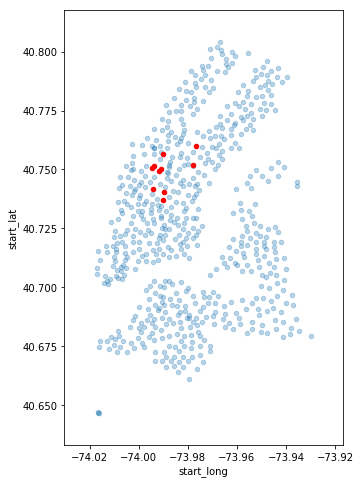

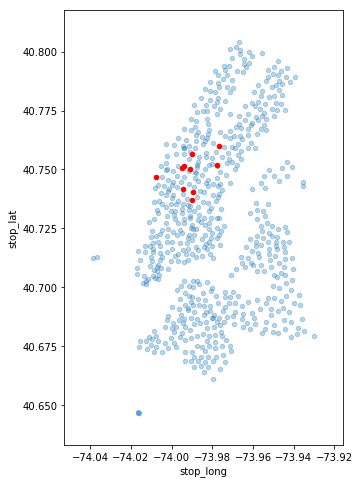

In [12]:
def plot_top_stations(df, x_values, y_values):
    pl = df.plot(kind = 'scatter', x = x_values, y = y_values, 
                alpha = 0.3, figsize = (5,8))
    df.head(10).reset_index().plot(kind = 'scatter', x = x_values,
                 color = 'r', y = y_values, ax = pl)

plot_top_stations(top_starts, 'start_long', 'start_lat')
plot_top_stations(top_stops, 'stop_long', 'stop_lat')

## Rebalancing

In [22]:
# examine transfers from before and after a given trip

def pre_trip_xfer(df):
    '''the first trip is isis removed, and a False value is added later'''
    mask = (df.start_id.values[1:] != df.stop_id.values[:-1])
    # add False to the first item, and reture a single array
    mask = np.hstack((False, mask))
    return df[mask].index.values # return value is an array, hence capable of groupby

# find index where the bike's current end station is not *next* start station
# hence is bike is xferrt chain

def post_trip_xfer(df):
    '''the last trip is removed, and a False value is added later'''
    mask = (df.start_id.values[1:] != df.stop_id.values[:-1])
    # add False to the first item, and reture a single array
    mask = np.hstack((mask, False))
    return df[mask].index.values  # return value is an array, hence capable of groupby

In [25]:
from itertools import chain

def find_xfers(df, pre_or_post = ''):
    
    # for IN xfers, use pre_or_post = 'pre', 
    # for OUT xfers,  use pre_or_post = 'post'
    if pre_or_post == 'pre':
        by_bike_id = df.groupby('bike_id').apply(pre_trip_xfer)
    elif pre_or_post == 'post':
        by_bike_id = df.groupby('bike_id').apply(post_trip_xfer)
    else: 
        raise Exception('Please specifiy "pre" or "post"')
        
    xfer_trip_ids = list(chain.from_iterable(by_bike_id.values))
    return df[df.index.isin(xfer_trip_ids)]

xfers_in = find_xfers(df, pre_or_post = 'pre')
xfers_out = find_xfers(df, pre_or_post = 'post')

In [36]:
#visualize rebalancing (with Bokeh)
import bokeh.plotting as bkp
import bokeh.models as bkm
import bokeh.charts as bkc
from bokeh.layouts import gridplot

N = 20  # number of top choices
station_lists = [0, 0]
station_lists[0] = xfers_in.groupby('start_id').apply(
                        lambda x: x.trip_id.count()).sort_values(ascending = False)[:N]
station_lists[1] = xfers_out.groupby('stop_id').apply(
                        lambda x: x.trip_id.count()).sort_values(ascending = False)[:N]

In [48]:
# output to notebook
bkp.output_notebook()

ps = [0, 0]  # initilized the list
source = [0, 0]  # initilized the list
colors = ['navy', 'red']  # ['In', 'Out']
labels = ['Out - In','In - Out']

for i, item in enumerate(['Transferred IN', 'Transferred OUT']):
    source[i] = bkp.ColumnDataSource(
    data = dict(station = list(map(str, station_lists[i].index)),
                count = station_lists[i].values,
                name = [stations.loc[x, 'name'] for x in station_lists[i].index],
                diff = [(-1)**(i+1)*station_count.loc[str(x), 'diff'] for x in station_lists[i].index]))
                        
    ps[i] = bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 tools = 'pan,box_zoom,reset,resize,save', 
                 x_range = list(map(str, station_lists[i].index)),
                 x_axis_label='Station id', y_axis_label = 'Counts', title = item)
    show = ps[i].vbar('station', top = 'count', width = 0.8, alpha = 0.5, line_alpha = 0.0,
               source = source[i], color = colors[i])
    ps[i].vbar('station', top = 'diff', width = 0.8, alpha = 1, line_alpha = 0.0,
               source = source[i], color = 'black')
    ps[i].xaxis.major_label_orientation = np.pi/4
    hover = bkm.HoverTool(tooltips=[('Station','@name'), 
                                    (item, '@count'),
                                    (labels[i],'@diff')], renderers=[show] )
    ps[i].add_tools(hover)
grid = gridplot([ps])

bkp.output_file('most_xferred_stations_'+str(year)+'.html')
bkp.show(grid) 
bkp.save(grid)

Loading BokehJS ...

'/home/psamtik071/Desktop/Projects/Rebalancing-Citibike/most_xferred_stations_2017.html'

In [15]:
by_bike_id.shape

(9765,)

In [16]:
# find bikes by bike id
bike_ids = df.id.unique()
bike_trajectory = df[df.id == bike_ids[0]][['id', 'start_id', 'stop_id', 
                                            'start_time', 'stop_time',
                                           'start_long', 'start_lat',
                                           'stop_long', 'stop_lat']]

# find and link up bike trajectories to find rebalancing events
rebal_events = pd.DataFrame(columns = bike_trajectory.columns)
rebal_list = []

def find_rebal_events(traj, pre_or_post = 'pre'):
# find rebalancing events
    mask = (df.start_id.values[1:] != df.stop_id.values[:-1])
    if pre_or_post == 'pre':
        mask = np.hstack((False, mask))
    elif pre_or_post == 'post':
        masp = np.hstack((mask, False))

'''
    for bike_id in bike_ids[:10]:
        one_traj = df[df.id == bike_id][bike_trajectory.columns]
        #trajectories = pd.concat([trajectories, one_traj], ignore_index = True)

        # track rebalancing events by shifting down stop times (and locations)
        shift_cols = ['stop_id','stop_time', 'stop_long','stop_lat']
        one_traj[shift_cols] = one_traj[shift_cols].shift(1)
        
 

        # filter where start and stop station ids are unequal
        rebal = one_traj[one_traj.start_id != one_traj.stop_id]
        rebal = 
        rebal_list.append(rebal)
'''

find_rebal_events(df)

    

AttributeError: 'DataFrame' object has no attribute 'id'

In [ ]:
rebal_list

In [ ]:
# track rebalancing events
shift_cols = ['stop_id','stop_time', 'stop_long','stop_lat']
bike_trajectory[shift_cols] = bike_trajectory[shift_cols].shift(1)
bike_trajectory.head()
rebal_events = bike_trajectory[bike_trajectory.start_id != bike_trajectory.stop_id]
rebal_events.shape

In [ ]:
stations = tuple(df.start_id.unique())= tuple(df.start_id)
lats = pd.Series()
longs = pd.Series()
names = pd.Series()
#for station in stations.station:   

In [ ]:
len(stations)